# Grid and Feature Contribution

This document shows the procedure of grid search and feature contribution investigation. 

In [189]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix,roc_curve
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import silhouette_samples, silhouette_score

from treeinterpreter import treeinterpreter as ti
import matplotlib.cm as cm
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sv = survey('data/survey2/')

In [3]:
sv.num_processor()

In [4]:
df = sv.fin_data

In [6]:
dfc = df.copy()
dfc['educom'] = (dfc.paeduc+dfc.maeduc+dfc.speduc)/3        
dfc.drop(['paeduc','maeduc','speduc'], axis =1, inplace=True)
y = dfc.pop('employed').values
X = dfc.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

### 1. Fit random forest model

In [8]:
rf = RandomForestClassifier(n_jobs=-1,random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Take first 30 important features to model

In [9]:
f30 = rf.feature_importances_.argsort()[::-1][:30]
rf_redu = RandomForestClassifier(n_jobs=-1,random_state=0)
slct=dfc.columns[f30]   #selected features
X = dfc[slct].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

In [11]:
rf_redu.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## 2. Grid search

In [44]:
#1st round
# rf_grid = {'max_depth': [3, None], 
#                       'max_features': ['sqrt', 'log2', None],
#                       'min_samples_split': [1, 2, 4],
#                       'min_samples_leaf': [1, 2, 4],
#                       'bootstrap': [True, False],
#                       'n_estimators': [10, 20, 40],
#                       'random_state': [1]}

#2nd
rf_grid = {'max_depth': [None], 
           'criterion':['gini','entropy'],
                      'max_features': ['log2', None],
                      'min_samples_split': [1],
                      'min_samples_leaf': [2],
                      'bootstrap': [True, False],
                      'n_estimators': [30, 40,80],
                      'random_state': [1]}

#3rd 
rf_grid = {'max_depth': [None], 
           'criterion':['gini'],
                      'max_features': ['log2',None],
                      'min_samples_split': [1],
                      'min_samples_leaf': [2],
                      'bootstrap': [False],
                      'n_estimators': [60,80,100],
                      'random_state': [1]}
#last round
rf_grid = {'max_depth': [None], 
           'criterion':['gini'],
                      'max_features': ['log2',None],
                      'min_samples_split': [1],
                      'min_samples_leaf': [2],
                      'bootstrap': [False],
                      'n_estimators': [230,250,300],
                      'random_state': [1]}

In [45]:
rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             rf_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')

In [46]:
rf_gridsearch.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   29.9s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [230, 250, 300], 'min_samples_split': [1], 'random_state': [1], 'criterion': ['gini'], 'max_features': ['log2', None], 'bootstrap': [False], 'max_depth': [None], 'min_samples_leaf': [2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc',
       verbose=True)

In [47]:
rf_gridsearch.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 1,
 'n_estimators': 300,
 'random_state': 1}

In [49]:
best_rf = rf_gridsearch.best_estimator_

roc_auc_score : 0.818305210155


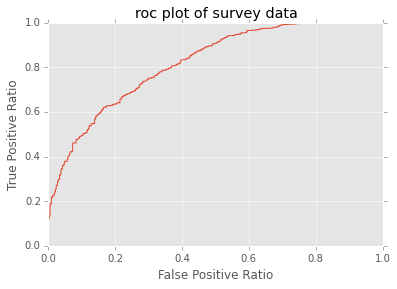

In [51]:
plot_roc(best_rf,X_test,y_test)

### 3.  Tree Interpreter and Feature Contribution

In [ ]:
prediction, bias, contributions = ti.predict(best_rf, X_test)

#### make feature contribution data frame

In [137]:
fc_df = pd.DataFrame(contributions[:,:,1], columns=slct)

In [140]:
fc_df['predict'] = best_rf.predict(X_test)    # predicted result

In [141]:
fc_df['employed'] = y_test                   # true result

In [151]:
fc_df['correct'] = fc_df.predict == fc_df.employed      # check if the prediction is correct

In [156]:
fc_df = fc_df[fc_df.correct == True]                #subset correct instances

In [168]:
fc_emp = fc_df[fc_df.employed == True].iloc[:,:-3]    # true-predicted-employed

In [169]:
fc_unemp = fc_df[fc_df.employed == False].iloc[:,:-3]   # true-prediction-umployed

### Cluster each fc

## 1. Employed group

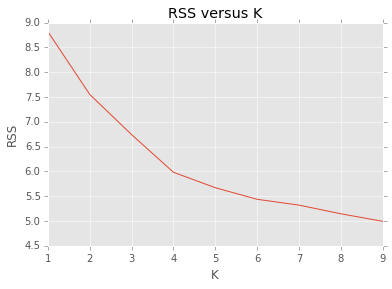

In [179]:
plot_kmean(fc_emp.values,10)

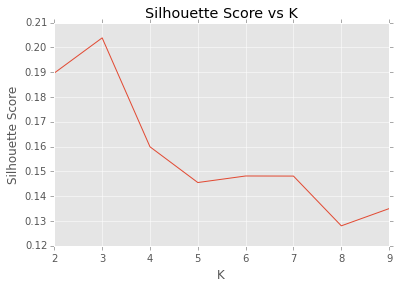

In [199]:
plot_silhouette(fc_emp.values,10)

('For n_clusters =', 3, 'The average silhouette_score is :', 0.20384255140025434)


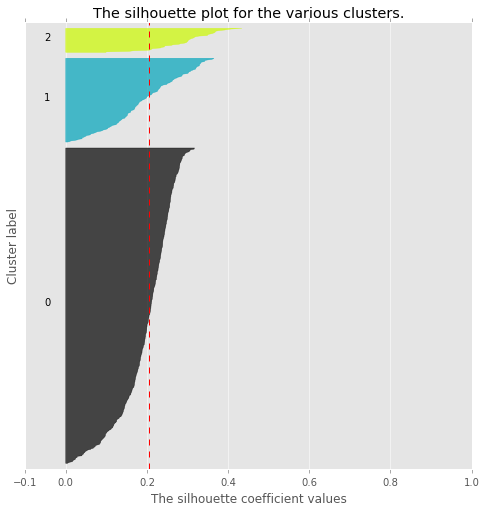

In [206]:
cluster_plot(fc_emp.values,3)

3 cluster would be fine?

In [207]:
km = KMeans(n_clusters=3)

In [208]:
km.fit(fc_emp.values)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [227]:
emp_cnt = pd.DataFrame(km.cluster_centers_,columns=slct)

In [232]:
for row in emp_cnt.values:
    print sorted(zip(row,slct),key=lambda x: abs(x[0]), reverse=True)[:3]

[(0.031542196441606336, 'coninc'), (-0.026323822505983217, 'divorce'), (0.010201960784407035, 'degree')]
[(-0.058423615724260851, 'coninc'), (0.017113483973137188, 'degree'), (0.016694834822037641, 'class_')]
[(0.046596321319259615, 'coninc'), (0.04004419550158473, 'divorce'), (0.017582540667332551, 'sphrs1')]


In [234]:
fc_emp['cluster'] = km.labels_

In [238]:
fc_emp1 = 'cluster')

In [239]:
dictn = extr_val_labels('data/survey2/GSS.sps')

In [98]:
inst = X_test[:3,:]

pred, bia, ctbn = ti.predict(best_rf, inst)

In [123]:
for i in range(len(inst)):
    print "Instance", i
    print "Bias (trainset mean)", bia[i]
    print "Prediction", pred[:,1][i]
    print "Feature contributions:"
    for c, feature in sorted(zip(ctbn[i,:,1], slct),key = lambda x: abs(x[0]),reverse=True):
        print feature, round(c, 2)
    print "-"*20 

Instance 0
Bias (trainset mean) [ 0.35453964  0.64546036]
Prediction 0.921111111111
Feature contributions:
coninc 0.05
divorce 0.04
fefam 0.03
degree 0.03
sphrs1 0.02
chldidel -0.02
age 0.02
fechld 0.02
socbar 0.02
educom 0.01
finrela 0.01
res16 -0.01
agekdbrn -0.01
meovrwrk 0.01
fund 0.01
partyid 0.01
courts 0.01
helpoth 0.01
reliten 0.01
incom16 0.01
natrace 0.01
class_ 0.01
polviews 0.0
workhard -0.0
mawrkgrw 0.0
natsoc -0.0
natroad 0.0
dwelling 0.0
socfrend -0.0
parsol -0.0
--------------------
Instance 1
Bias (trainset mean) [ 0.35453964  0.64546036]
Prediction 0.4258440108
Feature contributions:
incom16 -0.07
divorce -0.06
finrela -0.03
polviews -0.02
courts -0.02
educom 0.02
degree 0.02
fefam -0.01
dwelling -0.01
agekdbrn 0.01
natrace -0.01
sphrs1 -0.01
age -0.01
fechld 0.01
natsoc 0.01
socbar 0.01
mawrkgrw -0.01
coninc -0.01
chldidel -0.01
workhard -0.0
res16 0.0
socfrend 0.0
fund -0.0
partyid -0.0
parsol -0.0
natroad -0.0
helpoth -0.0
meovrwrk 0.0
reliten -0.0
class_ -0.0
----